This notebook handles exploratory data analysis for the combined dataset.

In [88]:
import os
import time
from tqdm import tqdm

import shapely
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
sns.set_theme()
sns.set_style("white")
sns.set_palette("rocket")

In [26]:
path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/SFPD_Crime_Data_Full.csv"
dataframe = pd.read_csv(path)

In [27]:
dataframe

,Date,Time,Day of Week,Category,Police District,Latitude,Longitude
0,2011/07/01,08:00,FRIDAY,WARRANTS,NORTHERN,37.802151,-122.439758
1,2005/10/18,14:30,TUESDAY,DRUG/NARCOTIC,TENDERLOIN,37.779944,-122.414318
2,2005/01/29,13:45,SATURDAY,VEHICLE THEFT,BAYVIEW,37.737576,-122.388799
3,2011/06/02,02:52,THURSDAY,NON-CRIMINAL,CENTRAL,37.803109,-122.414354
4,2003/02/01,08:00,SATURDAY,VEHICLE THEFT,BAYVIEW,37.724556,-122.401097
...,...,...,...,...,...,...,...
2364514,2020/08/15,19:05,SATURDAY,ASSAULT,TENDERLOIN,37.785790,-122.412970
2364515,2020/08/15,20:44,SATURDAY,LARCENY THEFT,CENTRAL,37.788808,-122.411886
2364516,2020/08/15,08:00,SATURDAY,NON-CRIMINAL,NORTHERN,37.792263,-122.436204
2364517,2020/08/15,21:52,SATURDAY,RECOVERED VEHICLE,TARAVAL,37.741234,-122.474494


The DataFrame contains the following columns:

* Date: day the incident occured, in YYYY-MM-DD format.
* Time: time the incident occured, in HH:MM miliary time.
* Day of Week: day of week the incident occured.
* Category: the classification of the incident.
* District: the police district where the incident occured.
* Latitude: the latitude of the coordinates where the incident occured.
* Longitude: the longitude of the coordinates where the incident occured.

### Date Analysis

* In this section we explore the distribution of crimes as a function of subsets of the date (i.e. year, month, day).

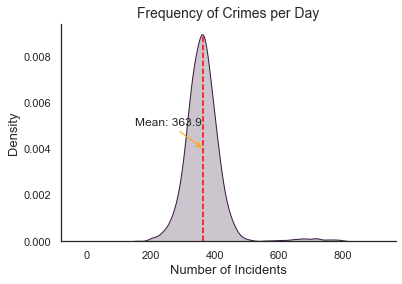

In [60]:
# Create the KDE plot.
date_frequency_data = dataframe.groupby("Date").count().iloc[:, 0]

sns.kdeplot(data=date_frequency_data, shade=True)
plt.axvline(x=date_frequency_data.mean(), ymax=0.95, linestyle="--", color="red")

# Make the plot readable and understandable.
plt.annotate("Mean: " + str(round(date_frequency_data.mean(), 1)), xy=(date_frequency_data.mean(), 0.004), arrowprops={"arrowstyle": "->", "color": "orange"}, xytext=(150, 0.005))
plt.title("Frequency of Crimes per Day", fontdict={"fontsize": 14})
plt.xlabel("Number of Incidents", fontdict={"fontsize": 13})
plt.ylabel("Density", fontdict={"fontsize": 13})
sns.despine()

There is an average of 364 crimes that occur every single day, with a standard deviation of (insert standard deviation here).

Let's explore the distribution of crimes based on the year.

In [42]:
# Determine the distribution of crimes based on the year.
distribution_crime_year = dataframe["Date"].apply(lambda x: x.split("/")[0])
distribution_crime_year = distribution_crime_year.value_counts()
distribution_crime_year.sort_index(inplace=True)

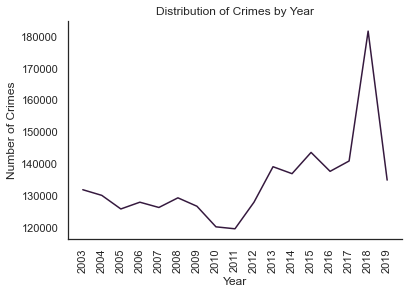

In [58]:
plt.plot(distribution_crime_year.index[:-1], distribution_crime_year.values[:-1])
_ = plt.xticks(rotation="vertical")
_ = plt.xlabel("Year")
_ = plt.ylabel("Number of Crimes")
_ = plt.title("Distribution of Crimes by Year")
sns.despine()

There was a decrease in crime for the years 2008 - 2011 followed by a steady increase until 2019 where there was a sharp drop in the number of crimes. Note that the data for 2020 was removed since the year has not completed at the time of this notebook.

Let's now explore the distribution of crimes based on the month. For this let's try to use a time-varying (based on the year) plot so that we can examine the distribution throughout the years.

In [103]:
# Extract the indices that correspond to each year.
years = [str(year) for year in range(2003, 2020)]
years_indices = {}
years_series = dataframe["Date"].apply(lambda x: x.split("/")[0])
for year in years:
    years_indices[year] = list(years_series[years_series == year].index)

KeyboardInterrupt: 

In [105]:
%%script false --no-raise-error
# For each of the years, precompute the number of crimes per month.
years_crime = {}
start_time = time.time()
for year in tqdm(years):
    indices = years_dict[year]
    crimes_per_month = np.zeros(12)
    for index in indices:
        month = int(dataframe.iloc[index]["Date"].split("/")[1]) - 1
        crimes_per_month[month] += 1
    years_crime[year] = crimes_per_month
end_time = time.time()

print("Entire operation took {} seconds.".format(end_time - start_time))

In [96]:
%%script false --no-raise-error
# Save the data because we don't want to compute it again.
import pickle as pkl

path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/distribution_by_year_per_month.pkl"

f = open(path, "wb")
pkl.dump(years_crime, f)
f.close()

The above two cells show how the distribution was pre-computed. The rest of the cells assume that the distribution has already been computed and saved.

In [108]:
# Load the distribution data.
path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/distribution_by_year_per_month.pkl"
distribution_year_month = pkl.load(open(path, "rb"))

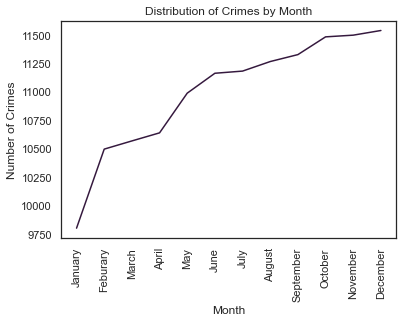

In [119]:
# Testcell: let's plot the data for the year 2003.
data_2003 = distribution_year_month["2003"]
labels_2003 = ["January", "Feburary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"] 

# Sort the data.
sort_key = data_2003.argsort()
data_2003.sort()
labels_2003[:] = [labels_2003[i] for i in sort_key]

# Plot the results.
plt.figure()
plt.plot(labels_2003, data_2003)

_ = plt.xticks(rotation="vertical")
_ = plt.xlabel("Month")
_ = plt.ylabel("Number of Crimes")
_ = plt.title("Distribution of Crimes by Month")

plt.show()

In [ ]:
# Create the 